In [2]:
from roboticstoolbox import DHRobot, RevoluteDH, PrismaticDH
from roboticstoolbox.tools.trajectory import mtraj, quintic, quintic_func
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

In [ ]:
# Dimensões e limites
L = [.3, .5870, 0]
qlim = [
    [-np.pi, np.pi],
    [np.deg2rad(90-13), np.deg2rad(90+61.5)],
    [0, .087]
]
offset = [0, 0, L[1]]  # Obs: d3 = L2 + q3
# Massas, centro de massas e inercias
m = [0.9112, 0, 1.3446]
cm = [
    [0, 0, 0.08],
    [0, 0, 0],
    [0, 0, 0.233]
]
I = [
    [1.6209e-5, 1.5989e-5, 9.6796e-7, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1.2403e-4, 2.4632e-4, 1.2389e-4, 0, 0, 0],
]
# Coeficientes de atrito viscoso e estático (Coulomb)
B = [0.001, 0.001, 0.0005]
Tc = [
    [0.02, -0.02],
    [0.015, -0.015],
    [0.01, -0.01]
]
# Denavit Hartenberg
a = [0, 0, 0]
d = [L[0], 0, 0]
alpha = [np.pi/2, np.pi/2, 0]
theta = [0, 0, np.pi/2]

# Elos (RRP)
link1 = RevoluteDH(
    d=d[0], a=a[0], alpha=alpha[0],offset=offset[0],
    qlim=qlim[0],m=m[0],r=cm[0],I=I[0],B=B[0],Tc=Tc[0],name='q1'
)
link2 = RevoluteDH(
    d=d[1], a=a[1], alpha=alpha[1],offset=offset[1],
    qlim=qlim[1],m=m[1],r=cm[1],I=I[1],B=B[1],Tc=Tc[1],name='q2'
)
link3 = PrismaticDH(
    theta=theta[2], a=a[2], alpha=alpha[2], offset=offset[2],
    qlim=qlim[2],m=m[2],r=cm[2],I=I[2],B=B[2],Tc=Tc[2],name='q3'
)
# Criando o robô
cocoabot = DHRobot([link1, link2, link3], name='Cocoabot')
print(cocoabot)

DHRobot: Cocoabot, 3 joints (RRP), dynamics, standard DH parameters
┌───────┬─────────────┬────┬───────┬─────────┬────────┐
│  θⱼ   │     dⱼ      │ aⱼ │  ⍺ⱼ   │   q⁻    │   q⁺   │
├───────┼─────────────┼────┼───────┼─────────┼────────┤
│  q1   │         0.3 │  0 │ 90.0° │ -180.0° │ 180.0° │
│  q2   │           0 │  0 │ 90.0° │   77.0° │ 151.5° │
│ 90.0° │  q3 + 0.587 │  0 │  0.0° │     0.0 │  0.087 │
└───────┴─────────────┴────┴───────┴─────────┴────────┘

┌──┬──┐
└──┴──┘



In [4]:
# Condicoes de contorno
q0 = np.array([0, np.pi/2, 0])
qf = np.array([np.pi/2, (3/4)*np.pi, 0.08])
# Parâmetros
tf = 5.0 
t = np.linspace(0, tf, 300)
# Trajetória Polinômio de 5 grau
traj = mtraj(quintic, q0, qf, t)
q = traj.q
qd = traj.qd
qdd = traj.qdd

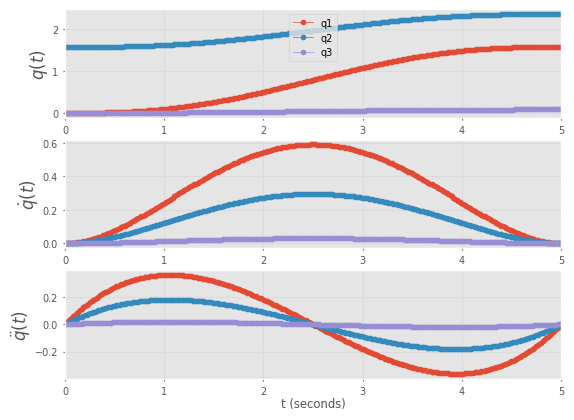

In [5]:
traj.plot()

In [6]:
# Cinemática direta
T = cocoabot.fkine(q)
# Cinemática inversa
q_cin = cocoabot.ikine_LM(T)
# Jacobianos
J = cocoabot.jacob0(q[0])       # da base
Jee = cocoabot.jacobe(q[0])     # do end-effector
sp.Matrix(J)
# Dinâmica
tau_din = cocoabot.rne(q, qd, qdd)          # Dinâmica inversa
qdd_din = cocoabot.accel(q, qd, tau_din)    # Dinâmica direta
G = cocoabot.gravload(q)             # G(q)
C = cocoabot.coriolis(q, qd)         # C(q, qd)
M = cocoabot.inertia(q)              # M(q)

In [7]:
import numpy as np

def coeff_traj(q0, qf, tf):
    D = qf - q0
    a0 = q0
    a1 = 0
    a2 = 0
    a3 = 10 * D / tf**3
    a4 = -15 * D / tf**4
    a5 = 6 * D / tf**5
    return a0, a1, a2, a3, a4, a5

def calc_traj(a, t):
    q   = a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4 + a[5]*t**5
    qd  = a[1] + 2*a[2]*t + 3*a[3]*t**2 + 4*a[4]*t**3 + 5*a[5]*t**4
    qdd = 2*a[2] + 6*a[3]*t + 12*a[4]*t**2 + 20*a[5]*t**3
    return q, qd, qdd


In [ ]:
q0 = np.array([0, np.pi/2, 0])
qf = np.array([np.pi/2, (3/4)*np.pi, 0.08])
tf = 5.0 

i = 2
t = 3
coeffs = coeff_traj(q0[i], qf[i], tf)
traj_i = lambda t: calc_traj(coeffs, t)
# Implementacao Peter Corke:
traj_rtb_i = quintic_func(q0[i], qf[i], tf)

# print('Coeficientes:', coeffs)
# traj_i(t), traj_rtb_i(t)

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/var/folders/bv/ksfk9dts11zch2h1t29kp9040000gn/T/ipykernel_4335/2342117202.py:6: SyntaxWarning: invalid escape sequence '\d'
  for ax, pos, lbl in zip(axs, y, ['$q(t)$', '$\dot q(t)$', '$\ddot q(t)$']):
/var/folders/bv/ksfk9dts11zch2h1t29kp9040000gn/T/ipykernel_4335/2342117202.py:6: SyntaxWarning: invalid escape sequence '\d'
  for ax, pos, lbl in zip(axs, y, ['$q(t)$', '$\dot q(t)$', '$\ddot q(t)$']):


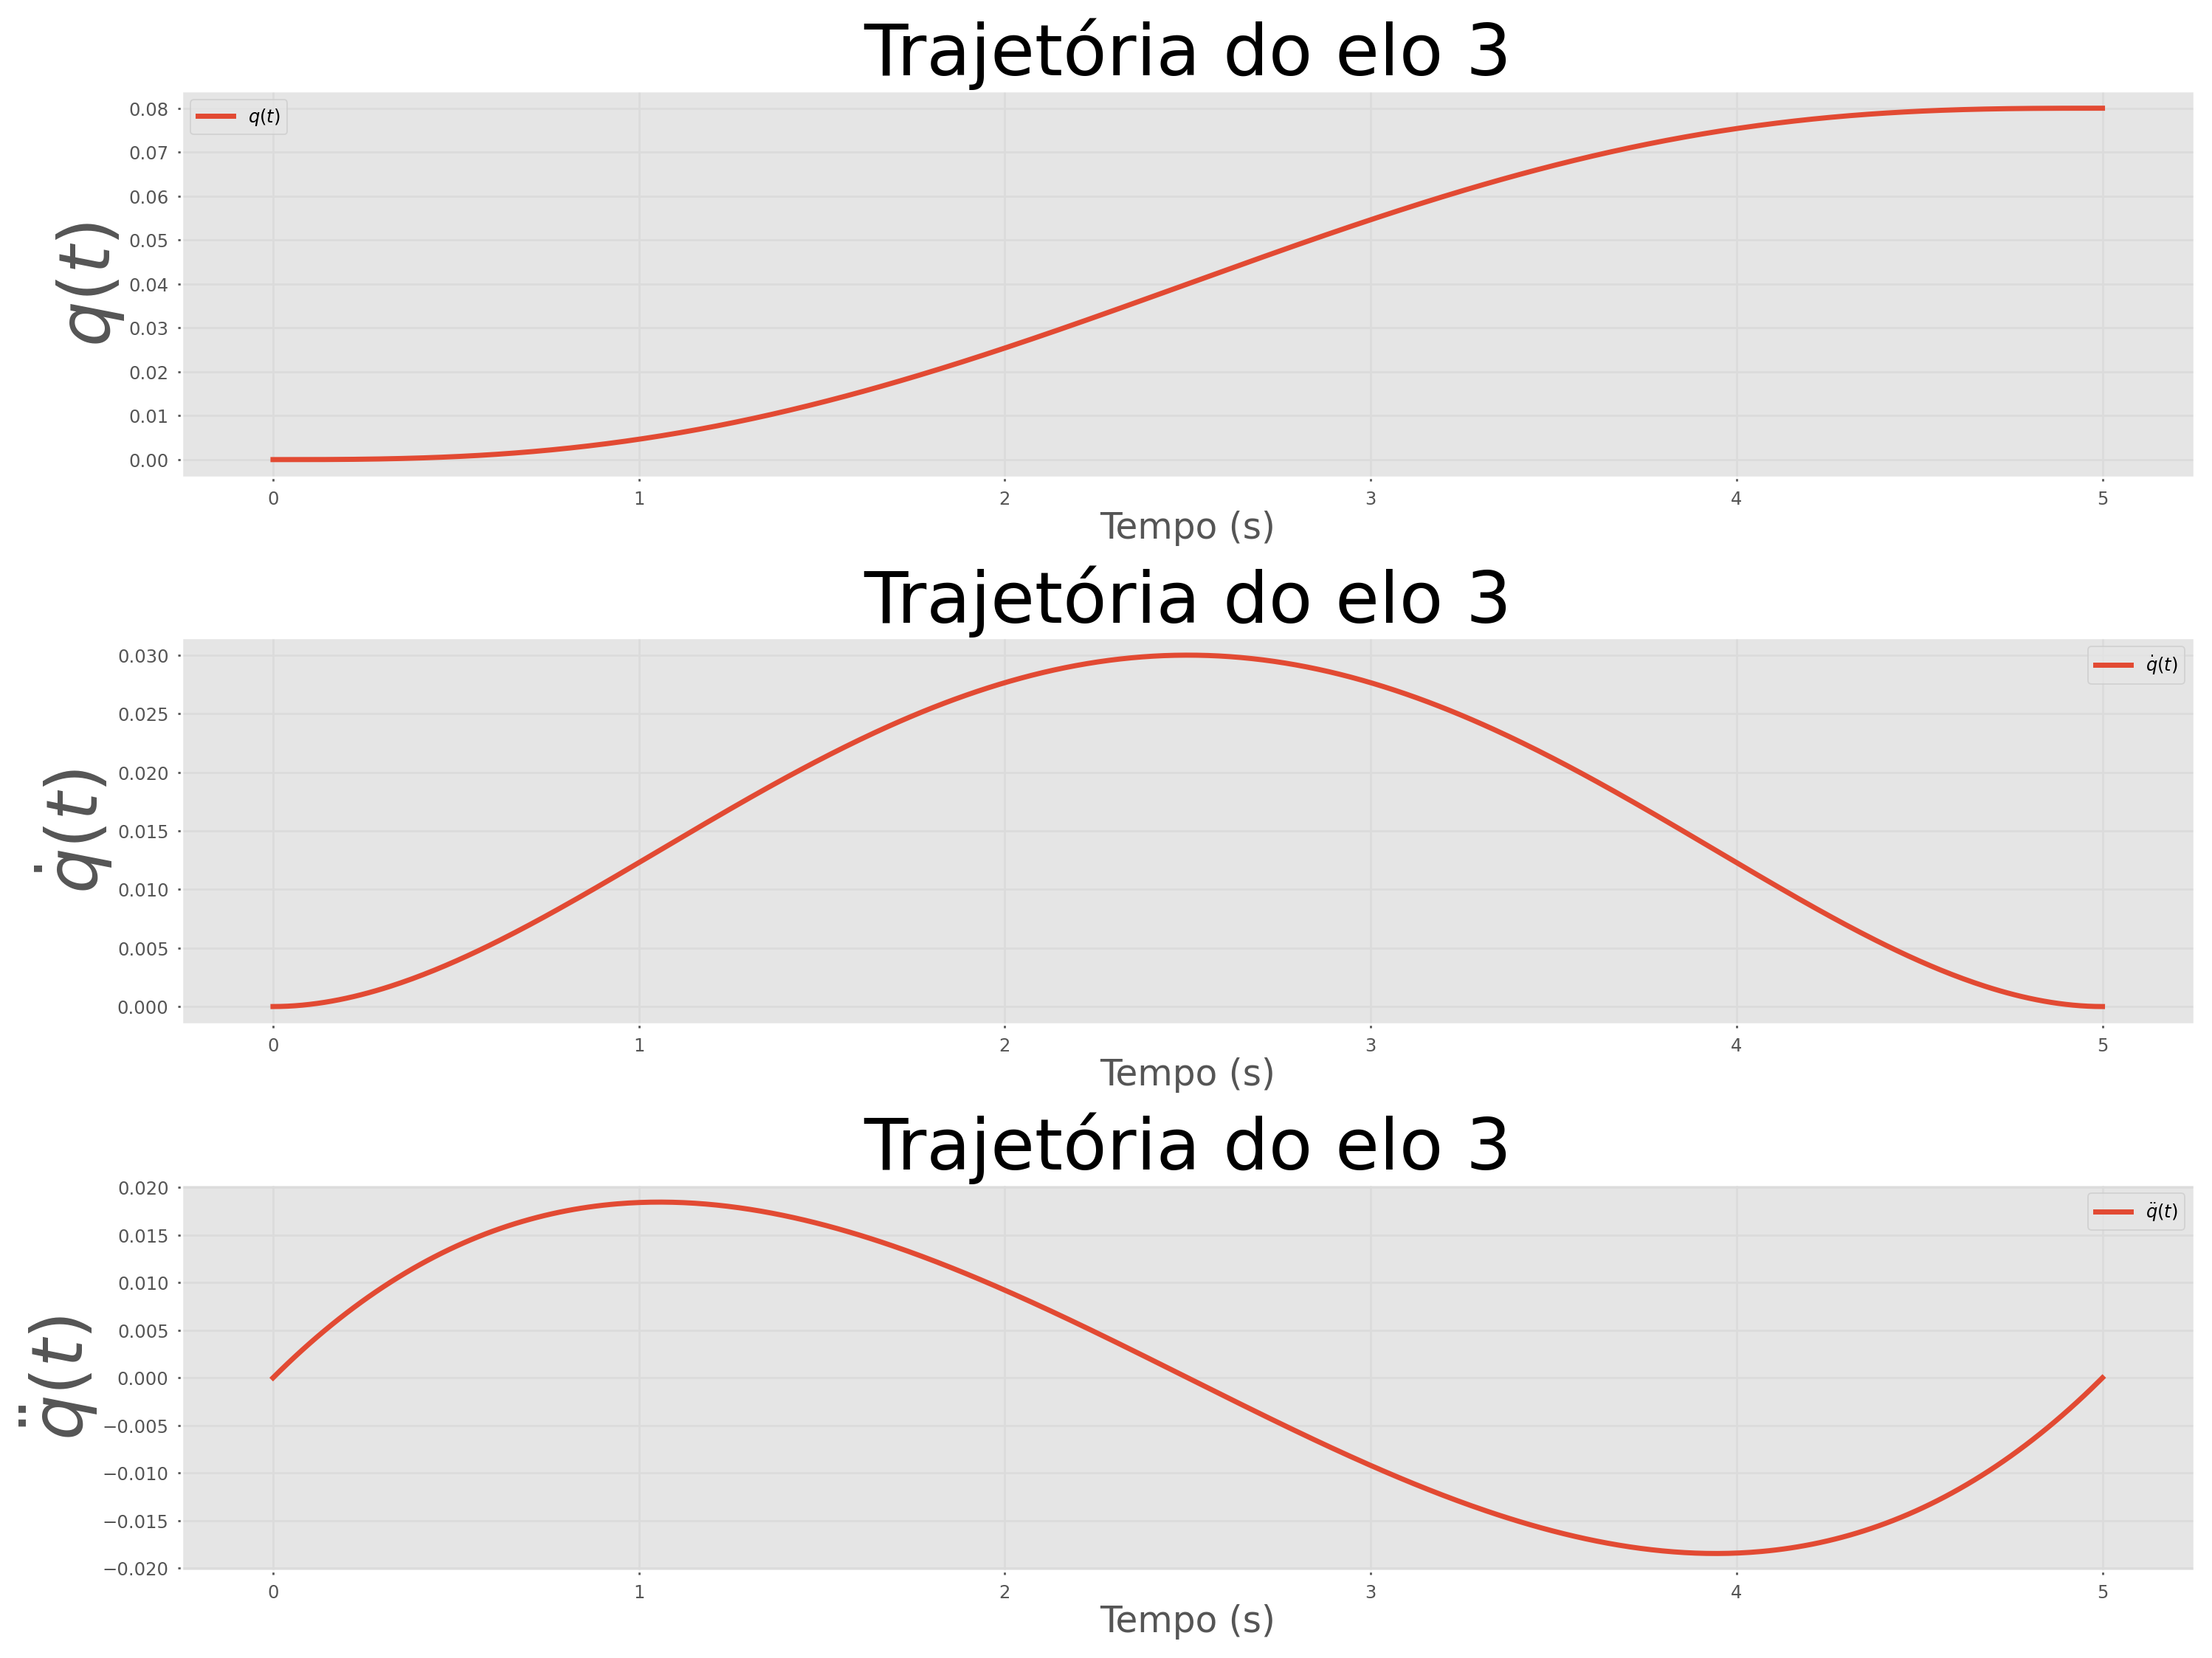

[0.08       0.02999976 0.01847494]


In [25]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(3, 1, dpi=250, figsize=(12, 3*3))
tgrid = np.linspace(0, tf, 500)
y = traj_i(tgrid)
for ax, pos, lbl in zip(axs, y, ['$q(t)$', '$\dot q(t)$', '$\ddot q(t)$']):
    ax.plot(tgrid, pos, label=lbl, lw=2)
    ax.set_xlabel('Tempo (s)', fontsize=14)
    ax.set_ylabel(lbl, fontsize=28)
    ax.set_title(f'Trajetória do elo {i+1}', fontsize=28)
    ax.legend()

plt.tight_layout()
plt.show()
print(np.max(y, axis=1))

In [ ]:
i = 150
M[i]

array([[8.53664107e-01, 3.74746224e-17, 0.00000000e+00],
       [3.74746224e-17, 9.95170382e-01, 0.00000000e+00],
       [5.97168127e-35, 0.00000000e+00, 1.34460000e+00]])

In [ ]:
M[np.argmax([np.linalg.norm(Mi) for Mi in M])]

array([[9.08113798e-01, 4.42399196e-17, 0.00000000e+00],
       [4.42399196e-17, 9.61521251e-01, 0.00000000e+00],
       [3.16062845e-33, 0.00000000e+00, 1.34460000e+00]])

In [ ]:
C[np.argmax([np.linalg.norm(Ci) for Ci in C])]

array([[-0.06684555, -0.19384584,  0.59056782],
       [ 0.19384584,  0.03448594,  0.33856492],
       [-0.59056782, -0.33856492,  0.        ]])